In [1]:
import numpy as np
import time
from ds1054z import DS1054Z
#%matplotlib inline
import matplotlib.pyplot as plt
from numpy.fft import fft
from numpy.fft import fftshift
from scipy.signal import blackmanharris
from matplotlib.ticker import EngFormatter

scope = DS1054Z('192.168.1.252')
print(scope.idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA192409533,00.04.04.SP3


In [4]:
def get_transfer(Ts,V1,V2):
    N=2**14
    X1A = 1/N*fftshift(fft(V1,N)) #N-point complex DFT
    X2A = 1/N*fftshift(fft(V2,N)) #N-point complex DFT

    mag1 = abs(X1A)
    mag2 = abs(X2A)

    Fs=1/(Ts[1]-Ts[0])
    df=Fs/N #%frequency resolution
    sampleIndex = np.arange(-N/2,N/2)
    f=sampleIndex*df

    thresh = 1/10

    X1B = np.copy(X1A)
    X1B[mag1 < max(mag1)*thresh] = 0
    phase1=np.arctan2(np.imag(X1B),np.real(X1B))*180/np.pi

    X2B = np.copy(X2A)
    X2B[mag2 < max(mag2)*thresh] = 0
    phase2=np.arctan2(np.imag(X2B),np.real(X2B))*180/np.pi
    
    fig, (ax1,ax2) = plt.subplots(2)
    ax1.plot(f,mag1)
    ax1.plot(f,mag2)
    ax2.plot(f,phase1)
    ax2.plot(f,phase2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_ylim([-180, 180])
    ax1.set_xlim([1e1,1e5])
    ax2.set_xlim([1e1,1e5])
    plt.show()
    
    f_single=f[int(N/2):N]
    mag1_single=mag1[int(N/2):N]
    index_of_peak1=mag1_single.argmax()
    #print('Peak Mag.',mag1[int(N/2)+index_of_peak1])
    print('at Freq.',f[int(N/2)+index_of_peak1])
    #print('with phase',phase1[int(N/2)+index_of_peak1],'deg')


    #print('Peak Mag.',mag2[int(N/2)+index_of_peak1])
    #print('at Freq.',f[int(N/2)+index_of_peak1])
    #print('with phase',phase2[int(N/2)+index_of_peak1],'deg')

    gain = (mag2[int(N/2)+index_of_peak1]) / (mag1[int(N/2)+index_of_peak1])
    phase_shift = (((phase2[int(N/2)+index_of_peak1]) - (phase1[int(N/2)+index_of_peak1])) + 180) % 360 - 180

    #print()
    print('gain:', gain)
    print('phase shift:', phase_shift)
    print()
    return (f[int(N/2)+index_of_peak1], gain, phase_shift)

Press Enter to continue...


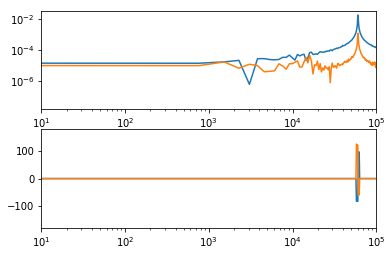

at Freq. 60272.216796875
gain: 0.06798109274276914
phase shift: -156.28375585810528



In [ ]:
data = []
for n in range(100):
    inn = input("Press Enter to continue...")
    if inn == 'q':
        break
    scale = scope.timebase_scale
    scope.timebase_scale = scale*100
    if(not scope.running):
        scope.run()
    time.sleep(1)
    scope.memory_depth = 120e3
    time.sleep(1)
    scope.single()
    time.sleep(1+scope.timebase_scale*12)
    V1 = scope.get_waveform_samples(1,mode='MAX')
    V2 = scope.get_waveform_samples(2,mode='MAX')
    Ts = scope.waveform_time_values
    scope.timebase_scale = scale
    scope.run()
    
    data.append(get_transfer(Ts,V1,V2))


In [ ]:
fig, (ax1,ax2) = plt.subplots(2)
f=[i[0] for i in data]
gain=[i[1] for i in data]
phase=[i[2] for i in data]
ax1.plot(f,20*np.log10(gain),'-o')
ax2.plot(f,phase,'-o')
ax1.set_xscale('log')
ax2.set_xscale('log')
plt.show()